## Imports

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import FK5
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import healpy as hp
import matplotlib.pyplot as plt
from astropy.coordinates import Angle
from astropy import units
from scipy.interpolate import RectBivariateSpline
from scipy import interpolate
import copy
import os
import sys
import pandas as pd
import healpy as hp
from astropy.constants import c, k_B,R_earth
from tqdm.notebook import tqdm
#from tqdm import tqdm
import glob
import h5py
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = "18"

PATH="/home/sonia/PRATUSH-PRATUSH_sensitivity/sky_models/"

#path_ms1 = '/home/pratush/Documents/saras3/'
#path_ms2 = '/home/pratush/Documents/saras3/utils'
#sys.path.append(path_ms1)
#sys.path.append(path_ms2)

#from ms_fit_joint import *
import scipy.io

## Define paths and constants

In [2]:
CHANNEL_WIDTH       = 0.06103515625/2.0 #/* MHz */
NUMBER_OF_CHANNELS  = 8193
START_FREQUENCY     = 0.00 #/* MHz */

PCHANNEL_WIDTH      = 16.0*0.06103515625 #/* MHz */
PNUMBER_OF_CHANNELS = 41
PSTART_FREQUENCY    = 210.44921875 #/* MHz */

RCHANNEL_WIDTH      = 16.0*0.06103515625 #/* MHz */
RNUMBER_OF_CHANNELS = 103
RSTART_FREQUENCY    = 109.86328125 #/* MHz */

QCHANNEL_WIDTH      = 16.0*0.06103515625 #/* MHz */
QNUMBER_OF_CHANNELS = 72
QSTART_FREQUENCY    = 39.5507812500 #/* MHz */

SITE_LATITUDE       =  -33.8688       #51.1657       -25.2744    #32.81302 #/* +32.77944444   deg for Hanle */ 
SITE_LONGITUDE      =   151.2093     # 10.4515       133.7751 #    78.87130 #/* 78.96416667 deg for Hanle */

NHPIX               = 3072
PI                  = 3.14159265358979

TCMB                = 2.72548

filename_coord      = "PIXEL_LISTING_NESTED_R4_GALACTIC.txt" #GMOSS

filename_pix_spec1  ="total_model_spec_13jan17_3072pix_103fq.txt"
filename_pix_spec2  ="total_model_spec_24jan17_1_3072_freq_40_110_MHz_16spacing.txt"
filename_pix_spec3  ="total_model_spec_31jan17_210_250_16spacing.txt"

beam_path  = '/home/sonia/rfi/elec_small_ant_with_2_12U_bus_cone_scale_0_925_ref_scale_0_9999'
rt_file    = 'gamma_linear.txt'
file_list  = sorted(glob.glob(os.path.join(beam_path,"*mhz.txt")))


##### Fitting constants

fmin = 56.0/1e3
fmax = 109.0/1e3

domain = 'log_log'
LOWF   = fmin*1e3
HGHF   = fmax*1e3
order  = 10

### Read FM Transmitter Database 

In [3]:
##### FM transmitter data for the countries: CANADA, AUSTRALIA ,GERMANY,USA and SOUTH AFRICA ####
##### EIRP in Watts #####
##### Latitude ranges from 90(N.Pole) to 0 (EQUATOR) to -90(S.Pole) ########
##### Longitude ranges between 0 and 360 degree eastwards ############

df=pd.read_csv("/home/sonia/rfi/Final_Revised.csv")
df.dropna(subset = ["Latitude in degrees"], inplace=True)

## Define some utility functions

In [4]:
def Read_Two_Column_File(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        for val, line in enumerate(data):
            if val==0:
                continue
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))
    return x, y

def Read_pixel_freq(file_name, nfreq):
    with open(file_name, 'r') as data:
        x = np.zeros((NHPIX, nfreq))
        for val, line in enumerate(data):
            if val==0:
                continue
            x[val-1] = [float(i) for i in line.split()]
    return x, np.shape(x)[1]

def select_freq_1d(x1, low, high): 
    prl = 0 
    prh = 0 
    for i in range(0, len(x1)):
        if x1[i]<=low:
            i_low=i+1
            prl = 1 
        if x1[i]>=high:
            i_high=i
            prh = 1 
            break
    if prl==1 and prh==0:
        i_high = len(x1)-1
    if prl==0 and prh==1:
        i_low = 1    
    return i_low, i_high

beam_monopole = lambda theta, phi: np.cos(np.radians(theta))**2 #Maxima at zenith #horizon
#beam_monopole_sidelobe = lambda theta, phi: 0.025*np.cos(np.radians(theta))**2


## Read Return Loss

In [5]:
gamme_file = os.path.join(beam_path, rt_file)

gamma_freq = []
gamma_val  = []

with open(gamme_file) as fa:
    for line_aa in fa.readlines()[3:]:
        line_aa = line_aa.strip()
        col1    = line_aa.split('\t')
        _freq   = np.array(list(map(float, col1[0].split())))[0]
        _val    = np.array(list(map(float, col1[1].split())))[0]
        gamma_freq.append(_freq)
        gamma_val.append(_val)
        
gamma_freq = np.array(gamma_freq)
gamma_val  = np.array(gamma_val)
    
gamma_func = scipy.interpolate.interp1d(gamma_freq, gamma_val)

## Read, process, and visualize beam files

In [6]:
phi_res   = 1
theta_res = 1

phi_array   = np.arange(0, 360, phi_res)
theta_array = np.arange(-90, 90 + theta_res, theta_res) #because arange does not accept endpoint. Stupid.
freq_array  = []
file_array  = []

def get_freq_from_file(filename):
    _temp = os.path.basename(filename).replace('.txt','').replace('mhz','')
    return float(_temp)
    
for ii, file_add in enumerate(file_list):
    freq_array.append(get_freq_from_file(file_add))
    file_array.append(file_add)
    
np.testing.assert_array_equal(file_array, file_list)

In [7]:
freq_array = np.array(freq_array)
file_array = np.array(file_array)

isort      = np.argsort(freq_array)
freq_array = freq_array[isort]
file_array = file_array[isort]

beam_3D_unnorm = np.zeros((len(freq_array), len(theta_array), len(phi_array)))

for ii, freq in enumerate(freq_array):
    print("Processing frequency {:.1f} MHz".format(freq))
    file_add = file_array[ii]
    with open(file_add) as fa:
        for line_aa in fa.readlines()[2:]:
            line_aa = line_aa.strip()
            col1    = line_aa.split('\t')
            all_val = np.array(list(map(float, col1[0].split())))

            theta   = all_val[0] - 90
            phi     = all_val[1]
            beam    = all_val[2]
            
            iphi    = np.where(phi_array==phi)[0][0]
            itheta  = np.where(theta_array==theta)[0][0]
            beam_3D_unnorm[ii, itheta, iphi] = beam

Processing frequency 55.0 MHz
Processing frequency 57.5 MHz
Processing frequency 60.0 MHz
Processing frequency 62.5 MHz
Processing frequency 65.0 MHz
Processing frequency 67.5 MHz
Processing frequency 70.0 MHz
Processing frequency 72.5 MHz
Processing frequency 75.0 MHz
Processing frequency 77.5 MHz
Processing frequency 80.0 MHz
Processing frequency 82.5 MHz
Processing frequency 85.0 MHz
Processing frequency 87.5 MHz
Processing frequency 90.0 MHz
Processing frequency 92.5 MHz
Processing frequency 95.0 MHz
Processing frequency 97.5 MHz
Processing frequency 100.0 MHz
Processing frequency 102.5 MHz
Processing frequency 105.0 MHz
Processing frequency 107.5 MHz
Processing frequency 110.0 MHz


In [8]:
beam_3D = np.zeros((len(freq_array), len(theta_array), len(phi_array)))
for ifreq in range(beam_3D.shape[0]):
    for iphi in range(beam_3D.shape[2]):
        beam_3D[ifreq,:,iphi] = beam_3D_unnorm[ifreq, :, iphi]/np.amax(beam_3D_unnorm[ifreq, :, iphi])

In [9]:
theta_array_new = theta_array
phi_array_new   = phi_array

In [10]:
from scipy.interpolate import RegularGridInterpolator
my_interpolating_function = RegularGridInterpolator((\
                                                     freq_array, theta_array_new, \
                                                     phi_array_new), beam_3D)

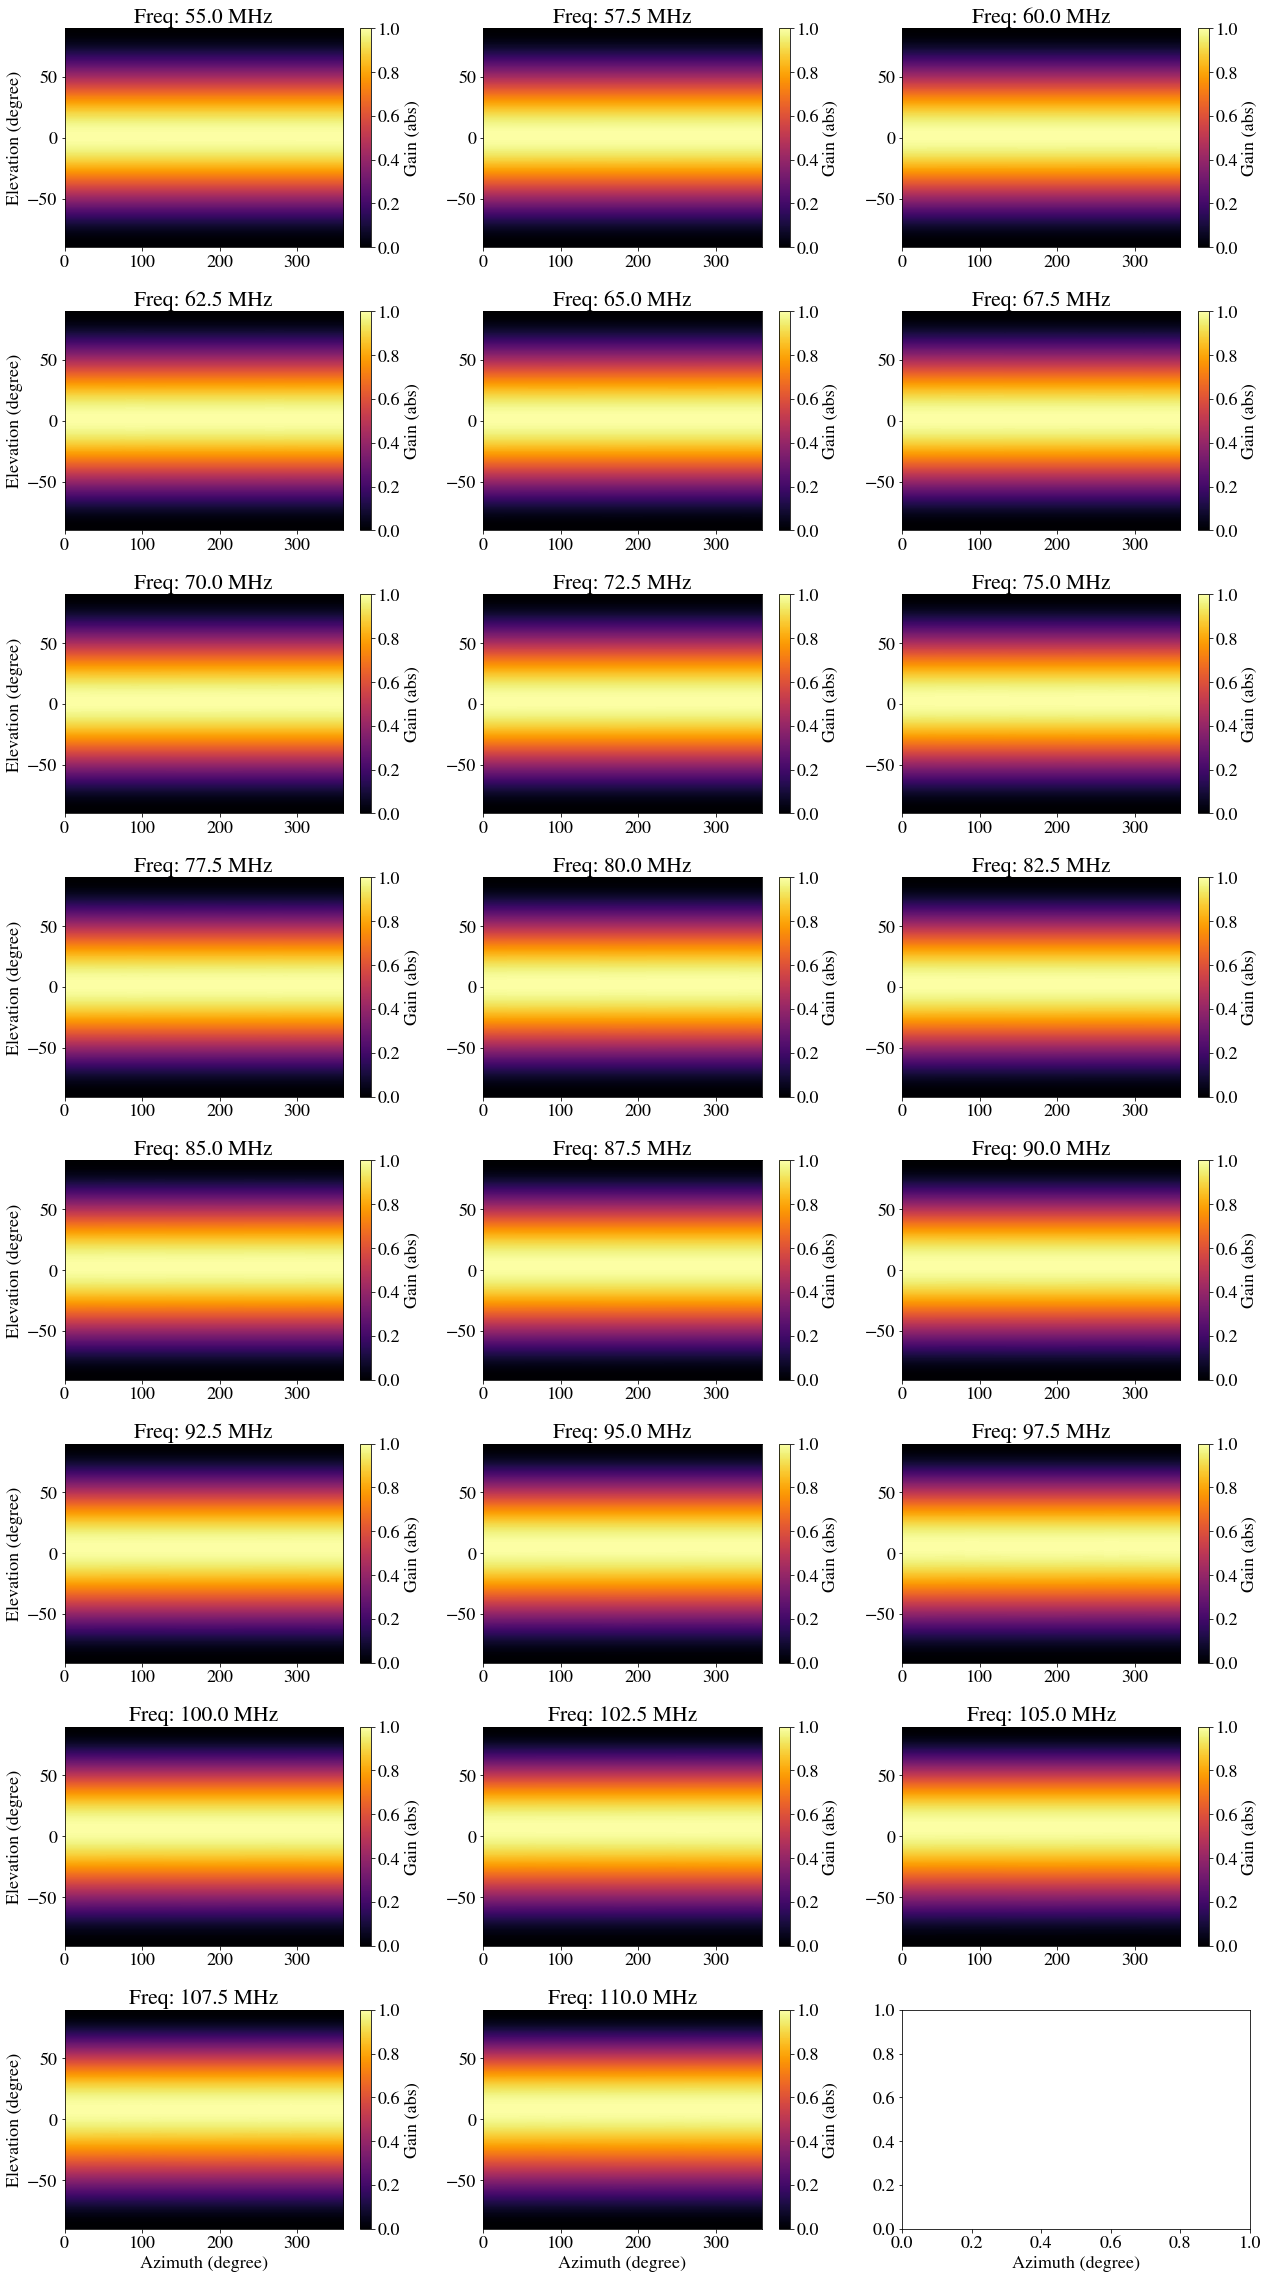

In [11]:
extent = (phi_array[0], phi_array[-1], theta_array[0], theta_array[-1])

nplots = len(freq_array)
ncol   = 3
nrow   = int(np.ceil(nplots/ncol))

fig, _ax = plt.subplots(nrow,ncol,figsize=(6*ncol,4*nrow))
axs      = np.ravel(_ax)

for val, (ax, freq) in enumerate(zip(axs, freq_array)):
    im = ax.imshow(beam_3D[val], aspect='auto', origin='lower', \
                   extent=extent, vmin=0, vmax=1, cmap='inferno')
    fig.colorbar(im, ax=ax, label='Gain (abs)')
    ax.set_title("Freq: {:.1f} MHz".format(freq))

for ax in _ax[:,0]:
    ax.set_ylabel("Elevation (degree)")
for ax in _ax[-1]:
    ax.set_xlabel("Azimuth (degree)")
    
fig.tight_layout()
plt.savefig("beam_plot", dpi=100)
plt.show()

In [12]:
nfreq, ntheta, nphi = beam_3D.shape
ind_phi_0 = np.argmin(np.abs(phi_array))

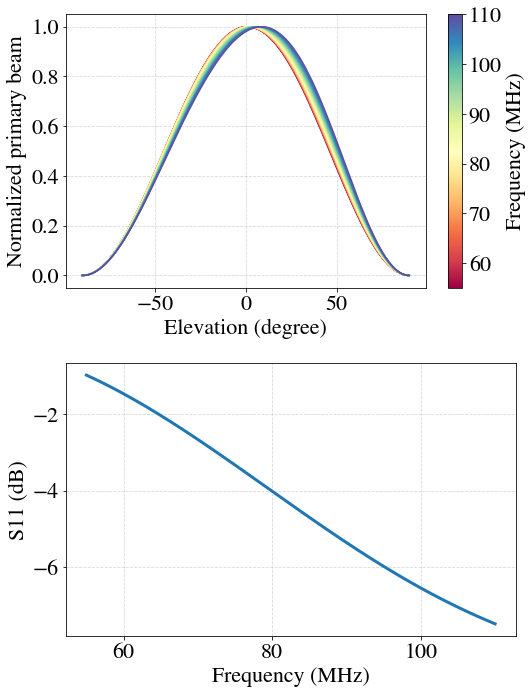

In [13]:
matplotlib.rcParams.update({'font.size': 22})

norm = matplotlib.colors.Normalize(vmin=55.0, \
                                   vmax=110.0)
c_m  = matplotlib.cm.Spectral
s_m  = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])


nrow, ncol = 2, 1
fig, _ax = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))

ax = _ax.ravel()

colors = plt.cm.Spectral(np.linspace(0,1,nfreq))

for ii in range(nfreq):
    sc=ax[0].plot(theta_array, beam_3D[ii,:,ind_phi_0], color=s_m.to_rgba(freq_array[ii]))
    
ax[0].set_xlabel("Elevation (degree)")
ax[0].set_ylabel("Normalized primary beam")
ax[0].grid(ls='--', alpha=0.5)
fig.colorbar(s_m, ax=ax[0], label='Frequency (MHz)',orientation="vertical")

FMIN, FMAX = 55, 110
ind_freq = np.logical_and(gamma_freq>=FMIN, gamma_freq<=FMAX)

ax[1].plot(gamma_freq[ind_freq], 20*np.log10(gamma_val[ind_freq]), lw=3.0)
ax[1].set_xlabel("Frequency (MHz)")
ax[1].set_ylabel("S11 (dB)")
ax[1].grid(ls='--', alpha=0.5)

fig.tight_layout()
    
plt.savefig("PRATUSH_antenna", dpi=100)
plt.show()

In [14]:
for val, (ax, freq) in enumerate(zip(axs, freq_array)):
    im = ax.imshow(beam_3D[val], aspect='auto', origin='lower', \
                   extent=extent, vmin=0, vmax=1, cmap='inferno')

## Read files from GMOSS and 21-cm atlas

In [15]:
ll_coordinate, bb_coordinate = np.radians(Read_Two_Column_File(PATH+filename_coord))

T1, nspec1 = Read_pixel_freq(PATH+filename_pix_spec1, RNUMBER_OF_CHANNELS)
T2, nspec2 = Read_pixel_freq(PATH+filename_pix_spec2, QNUMBER_OF_CHANNELS)
T3, nspec3 = Read_pixel_freq(PATH+filename_pix_spec3, PNUMBER_OF_CHANNELS)

freq    = np.zeros(nspec1+nspec2+nspec3)
T_pix   = np.zeros((NHPIX, nspec1+nspec2+nspec3))

for i in range(0, nspec2):
    freq[i]=(float)(QSTART_FREQUENCY/1000.0) +\
            ((float)(QCHANNEL_WIDTH)/1000.0)*(float)(i)
for i in range(nspec2, (nspec1+nspec2)):
    freq[i]=(float)(RSTART_FREQUENCY/1000.0) + ((float)(RCHANNEL_WIDTH)/1000.0)*(float)(i-nspec2)
for i in range(nspec1+nspec2, (nspec1+nspec2+nspec3)):
    freq[i]=(float)(PSTART_FREQUENCY/1000.0)+((float)(PCHANNEL_WIDTH)/1000.0)*(float)(i-(nspec1+nspec2))

for j in range(0, NHPIX):
    T_pix[j][0:nspec2]=T2[j]
    T_pix[j][(nspec2):(nspec1+nspec2)]=T1[j]
    T_pix[j][(nspec1+nspec2):(nspec1+nspec2+nspec3)]=T3[j]
    
freq_org, T_pix_org = copy.deepcopy(freq), copy.deepcopy(T_pix)

#data21   = scipy.io.loadmat(os.path.join(path_ms1, 'atlas/Data_18March_wMFP.mat'))
#data21   = data21['Data2']/1e3 
#fr       = np.loadtxt(os.path.join(path_ms1,'atlas/freq_saras.txt')) #Frequency in MHz
#signal   = interpolate.interp1d(fr, data21)

/home/sonia/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  newcm.set_over(newcm(1.0))
/home/sonia/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  newcm.set_under(bgcolor)
/home/sonia/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a 

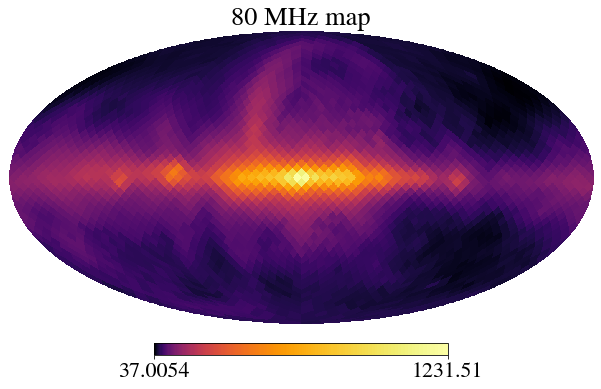

In [16]:
map1 = T_pix_org[:,215]
hp.mollview(map1,title="80 MHz map", norm='log', cmap='inferno', xsize=1400, nest=True)
#np.argmin(np.abs(80-freq_org))

plt.savefig("80_MHz", dpi=200)

## Covolve beam with GMOSS

In [17]:
ifr_low, ifr_hgh = select_freq_1d(freq_org, fmin, fmax)

freq  = freq_org[ifr_low:ifr_hgh]*1e3

T_pix = T_pix_org[:,ifr_low:ifr_hgh]

In [32]:
np.shape(T_pix)

(3072, 55)

In [20]:
%store freq

Stored 'freq' (ndarray)


In [70]:
freq

array([ 56.15234375,  57.12890625,  58.10546875,  59.08203125,
        60.05859375,  61.03515625,  62.01171875,  62.98828125,
        63.96484375,  64.94140625,  65.91796875,  66.89453125,
        67.87109375,  68.84765625,  69.82421875,  70.80078125,
        71.77734375,  72.75390625,  73.73046875,  74.70703125,
        75.68359375,  76.66015625,  77.63671875,  78.61328125,
        79.58984375,  80.56640625,  81.54296875,  82.51953125,
        83.49609375,  84.47265625,  85.44921875,  86.42578125,
        87.40234375,  88.37890625,  89.35546875,  90.33203125,
        91.30859375,  92.28515625,  93.26171875,  94.23828125,
        95.21484375,  96.19140625,  97.16796875,  98.14453125,
        99.12109375, 100.09765625, 101.07421875, 102.05078125,
       103.02734375, 104.00390625, 104.98046875, 105.95703125,
       106.93359375, 107.91015625, 108.88671875])

In [18]:
#### Array consisting of frequencies from the dataset
data_freq=df['Frequency(MHz)'].values

diff=np.zeros((len(data_freq),len(freq)),dtype=object)
freq_arr=np.zeros(len(data_freq))


for i in range(len(data_freq)):
    for j in range(len(freq)):
        diff[i][j]=abs(data_freq[i]-freq[j])
        freq_arr[i]=freq[np.argmin(diff[i])]

        
##### Create column to store the new frequencies based on the user defined frequency axis #####
df['New Frequency']=freq_arr

### Define resolution of the Healpy map

In [19]:
print('-----------Resolution of the map---------') 
nside = 16
print(f"The number of pixels for the given NSIDE: {(hp.nside2npix(nside))}")
print(f"Approximate resolution in degrees for given nside {np.degrees(hp.nside2resol(nside)):.2f}")
print( "Pixel area: %.2f square degrees" % hp.nside2pixarea(nside, degrees=True))


-----------Resolution of the map---------
The number of pixels for the given NSIDE: 3072
Approximate resolution in degrees for given nside 3.66
Pixel area: 13.43 square degrees


### Allocate pixel number to the Latitude and Longitude of each FM transmitter in the database

In [20]:
pixel_indices = hp.ang2pix(nside, df['Longitude in degrees'].to_numpy() ,df['Latitude in degrees'].to_numpy(),lonlat=True)
df['Pixel_number']=pixel_indices 


/home/sonia/anaconda3/lib/python3.8/site-packages/healpy/pixelfunc.py:475: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)


### Check for pixel number for a given pair of latitude and longitude in degree

In [22]:
###### Pixel numbers based on NSIDE=16 ########
### Germany(51.1657,10.4515)= 313, Australia(-25.2744,133.7751)=2167, Hanle(32.81302, 78.87130)= 686


#pixie = hp.ang2pix(nside,78.871,32.81 ,lonlat=True)
#pixie


### Conversion of the pixel numbers of the Healpy map to corresponding angular coordinates

In [21]:
NPIX = hp.nside2npix(nside) # Storing the number of pixels of the map corresponding to the given NSIDE
arr=np.arange(NPIX) #Create an an array of pixel numbers with respect to the NSIDE

phi,theta = (hp.pix2ang(nside, ipix=arr,lonlat=True)) # Array of the angular coordinates co-latitude(theta) 
                                                        #and longitude(phi) in degrees 
                                                       # With respect to the given NSIDE

### Define altitude of the satellite orbit 

In [22]:
#Creating user defined data points between 400 km to 36000 km in log scale
data_point=int(input("Enter number of data points : "))
altitude= np.logspace(np.log10(400),np.log10(36000),data_point) 
print(altitude)


Enter number of data points : 2
[  400. 36000.]


### Calculation of Elevation angle

In [23]:
x_ang=np.zeros((NPIX,NPIX))
y_ang=np.zeros((NPIX,NPIX))
elev_ang=np.zeros((len(altitude),NPIX,NPIX))
R_E=R_earth.to('km').value
for k in range(len(altitude)):
    for i in range(len(theta)):
        for j in range(len(theta)):
        
            x_ang[i,j]=((np.cos(np.radians(theta[i])))*(np.cos(np.radians(theta[j])))*(np.cos(np.radians(phi[j]-phi[i])))+(np.sin(np.radians(theta[i])))*(np.sin(np.radians(theta[j]))))
            y_ang[i,j]=(np.arccos(x_ang[i,j]))
            B=(altitude[k]+R_E)/R_E
            elev_ang[k,i,j]=-(np.degrees(np.arctan((B-np.cos(np.radians(y_ang[i,j])))/np.sin(np.radians(y_ang[i,j]))))-y_ang[i,j])

<ipython-input-23-a9cf50e69add>:12: RuntimeWarning: divide by zero encountered in double_scalars
  elev_ang[k,i,j]=-(np.degrees(np.arctan((B-np.cos(np.radians(y_ang[i,j])))/np.sin(np.radians(y_ang[i,j]))))-y_ang[i,j])
<ipython-input-23-a9cf50e69add>:10: RuntimeWarning: invalid value encountered in arccos
  y_ang[i,j]=(np.arccos(x_ang[i,j]))


###  Calculation of Field of view (FOV) and Radius of the FOV of the satellite

In [24]:
###########-----------------Considering Nadir-pointing Field of View Geometry-------######
##########-----------------Considering the FOV of the satellite to be tangent to the surface of the Earth------######


FOV=np.zeros(len(altitude))
for i in range(0,len(altitude)):
# Consider a case of full coverage under elevation of 0 º
   
    FOV[i]= 2*np.arcsin(R_E/(R_E+ altitude[i]))  # Field of view for maximal coverage in radians when elevation is 0 º 
    print(" The Field of view of the satellite at a height of",altitude[i],"km is",FOV[i], "radians")

 The Field of view of the satellite at a height of 400.0000000000001 km is 2.4510662859463395 radians
 The Field of view of the satellite at a height of 35999.99999999996 km is 0.3021573821256571 radians


In [25]:
# The surface of the coverage area of the Earth depends on the central angle
Central_angle=np.zeros(len(altitude))
for i in range(0,len(altitude)):
    Central_angle[i]=np.arccos(R_E/(R_E+altitude[i])) # Central angle in radians
    
    Dia_of_FOV=2*Central_angle*R_E  # Diameter of the FOV (disc on the Earth's surface)in km
    Rad_of_FOV= Dia_of_FOV/2 # Radius of the FOV in km
    Rad_of_FOV=Rad_of_FOV/R_E  # Radius of the FOV in Radians
    print(" The Radius of the Field of View for a height of",altitude[i],"km in radians is",Rad_of_FOV[i])

 The Radius of the Field of View for a height of 400.0000000000001 km in radians is 0.34526318382172694
 The Radius of the Field of View for a height of 35999.99999999996 km in radians is 1.419717635732068


# Create power cube 

In [26]:
###############-----Storing indices of the pixel number that are inside the circle/disc(FOV) wrt the altitude-----------######


vec1 = hp.ang2vec(phi,theta,lonlat=True) #Using ang2vec convert angles that is co-latitude and longitude in radians
                                        #to 3D position vector
    
disc=np.zeros((len(arr),len(Rad_of_FOV)),dtype=object)#Array of indices of the pixel number that are inside the 
                                                      #circle/disc specified by vec and radius
def pixel_disc(a,b):
    for i in range(len(a)):
        for j in range(len(b)):
            disc[j][i]=hp.query_disc(nside, vec1[j], radius=a[i])
pixel_disc(Rad_of_FOV,arr)

In [27]:
######-----Storing indices of the pixel number that are common between the FOV disc and the satellite pixel no------####


Comm_pix=np.zeros((len(disc[:,i]),len(Rad_of_FOV)),dtype=object)

for i in range(len(Rad_of_FOV)):
    for k in range(len(disc[:,i])):
     

         Comm_pix[k][i]=np.intersect1d(pixel_indices,disc[k][i])#Array of indices of the pixel number that are
                                                           #common between the FOV disc and the satellite pixel no
         
        

In [28]:
######-----Storing indices of the pixel number that are common between the FOV disc and the satellite pixel no ------#
######-----And the same pixel number of the transmitters-----##



######--- Initializing the array to store the pixel number that are common between the FOV disc ---####
######                        and the satellite pixel no    ######
Comm_TX=np.zeros((len(Comm_pix),len(Rad_of_FOV)),dtype=object)
found_common=np.zeros(( len(Comm_pix),len(Rad_of_FOV)),dtype=object)

for j in range(len(Rad_of_FOV)):
    for i in range(len(Comm_pix)):
        
        Comm_TX[i][j]=set(Comm_pix[i][j])
        found_common[i][j] = [l for l in pixel_indices if l in Comm_TX[i][j]]#Array of indices of the pixel number that 
                                            #are common between the FOV disc and the satellite pixel no with
                                                    # Tx having same pixel number
                                                                       

In [29]:
#######-------Store the values of the received power in Watt,dBm and Kelvin wrt altitude----#####
######------- Calculation of the received power using Friis Transmission Equation--------#######
######-------Considering isotropic transmitter and receiver with gain =1 -------------#########


res=61*1e3
Rx_Power= np.zeros((len(df),len(altitude)))
Rx_Power_in_Kelvin=np.zeros((len(df),len(altitude)))
Rx_Power_in_dBm=np.zeros((len(df),len(altitude)))
for i in range(0,len(altitude)):
    for j in range(0,len(df)):
        wavelength= c.value/(df.iloc[j]['Frequency(MHz)']*1e6)
        Rx_Power[j][i]= ((df.iloc[j]['EIRP'])*(wavelength)**2)/(4*np.pi*altitude[i]*1e3)**2 #the Friis Transmission Equation
        Rx_Power_in_dBm[j][i]= 10.*np.log10( Rx_Power[j][i])+30
        Rx_Power_in_Kelvin[j][i]=Rx_Power[j][i]/(k_B.value*res)#in Kelvin
        

       

<ipython-input-29-079e2deed650>:14: RuntimeWarning: divide by zero encountered in log10
  Rx_Power_in_dBm[j][i]= 10.*np.log10( Rx_Power[j][i])+30


In [30]:
##### ---Create dataframe to store the values of the received power in Kelvin w.r.t the altitude----#####

##### The first three columns of the dataframe indicate the altitude [0=400 km, 1= 3794 km , 2= 36000 km ] #####
##### The column will vary with the user input for the number of altitudes ######

df_data=pd.DataFrame(Rx_Power_in_Kelvin)

df_data['Pixel_number']=pixel_indices
df_data['New Frequency']=freq_arr


In [34]:
az=0
azi=0

In [100]:
#########  Create dataframes for the FOV for each pixel position of the satellite at different altitudes #######

######--- Initializing the array to store the dataframes for the FOV for each pixel position of the satellite #####
######            at different altitudes   ######


df_1=np.zeros((len(found_common),len(Rad_of_FOV)),dtype=object)

for j in range(len(Rad_of_FOV)):
    for i in range(len(found_common)):
        df_1[i][j]= df_data.loc[df_data['Pixel_number'].isin(found_common[i][j])]
        #df_1[i][j][j]=df_1[i][j][j]*beam_monopole(elev_ang[j,i,found_common[i,j]],az)
        df_1[i][j]= df_1[i][j].groupby(['New Frequency']).sum()  # df9['Pixel_number']= Column consisting of 
        df_1[i][j]= df_1[i][j].reset_index() 

In [99]:
df_11=np.zeros((len(found_common),len(Rad_of_FOV)),dtype=object)

for j in range(len(Rad_of_FOV)):
    for i in range(len(found_common)):
        df_11[i][j]= df_data.loc[df_data['Pixel_number'].isin(found_common[i][j])]
       # df_11[i][j][j]=df_11[i][j][j]*beam_gen_rfi(elev_ang[j,i,found_common[i,j]],az)
        
        df_11[i][j]= df_11[i][j].groupby(['New Frequency']).sum()  # df9['Pixel_number']= Column consisting of 
        df_11[i][j]= df_11[i][j].reset_index()

In [101]:
## Initializing the 3D array to store the received power for each pixel, each frequency and at different altitudes ###

power_output=np.zeros((len(Rad_of_FOV),NPIX,len(freq)),dtype=object)


In [53]:
power_output1=np.zeros((len(Rad_of_FOV),NPIX,len(freq)),dtype=object)

In [102]:
## Create the 3D array to store the received power for each pixel, each frequency and at different altitudes ##
## k: loops along the length of the number of altitude
## m: loops along the length of the number of pixels based on the given NSIDE
## l: loops along the length of the number of frequencies in the frequency axis defined by user



for k in range(len(Rad_of_FOV)):
    for m in range(NPIX):    
        for l in range(len(freq)):
            if (df_1[m][k][k][df_1[m][k]['New Frequency'] == freq[l]].values).size==0:# checking for empty dataframes
                power_output[k][m][l]=0
            else: 
                power_output[k][m][l]=float(df_1[m][k][k][df_1[m][k]['New Frequency'] == freq[l]].values)

In [54]:
for k in range(len(Rad_of_FOV)):
    for m in range(NPIX):    
        for l in range(len(freq)):
            if (df_11[m][k][k][df_11[m][k]['New Frequency'] == freq[l]].values).size==0:# checking for empty dataframes
                power_output1[k][m][l]=0
            else: 
                power_output1[k][m][l]=float(df_11[m][k][k][df_11[m][k]['New Frequency'] == freq[l]].values)

In [213]:
power_output[1,2167, 35]

5174.807073233005

In [133]:
power_output[1,2167, 35]

71572684.8097655

In [103]:
#dt = TimeDelta(np.arange(0.,24.*3600,10000000), format='sec')
#dt = TimeDelta(np.linspace(0.,24.*3600, 3), format='sec') #Will take ~5 min

dt = TimeDelta(np.linspace(0.,24.*3600, 2), format='sec') #Will take ~5 min

obstimes = Time('2019-4-12 23:00:00') + dt

In [104]:
hanle = EarthLocation(lat=SITE_LATITUDE*u.deg, lon=SITE_LONGITUDE*u.deg, height=4500*u.m)
gc    = SkyCoord(l=ll_coordinate*u.radian, b=bb_coordinate*u.radian,\
        frame='galactic')


T_monopole_sky = np.zeros((obstimes.shape[0], freq.shape[0]))
T_monopole_RFI = np.zeros((obstimes.shape[0], freq.shape[0]))
T_RFI = np.zeros((obstimes.shape[0], freq.shape[0]))
T_SKY = np.zeros((obstimes.shape[0], freq.shape[0]))


#Get RA, DEC 
trans      = gc.transform_to('icrs')
ra, dec    = trans.ra.hour, trans.dec.hour

observing_time = Time(obstimes, scale='utc', location=hanle)
LST            = observing_time.sidereal_time('mean').value

##  P.S : 1) Run the next cell for PRATUSH beam only 
           2) The pixel number should correspond to the SITE_LATITUDE and SITE_LONGITUDE


<b> Note:For the the array power_output and elev_ang\
<b> The first index represents altitude of the satellite <b>\
<b> The second index represents location of the satellite(pixel number) <b>\
<b> The third index represents range of frequencies <b>

In [120]:
for val, (time,i) in enumerate(zip(obstimes, tqdm(range(len(obstimes))))):
    
    print("Processing time: {}".format(time))
   
    #Get Alt, Az
    
    trans_local                 = gc.transform_to(AltAz(obstime=time, location=hanle))
    az, alt                     = trans_local.az.degree, trans_local.alt.degree
   
    ind_below_horizon           = alt < 0
       
    ############################
    
    beam_gen = np.zeros_like(T_pix)

    for ifreq, freq_value in enumerate(freq):
        rogue_phi  = []
        for iangle, (alt_value, az_value) in enumerate(zip(alt, az)):
            
            if az_value > phi_array_new.max():
                rogue_phi.append(az_value)
                az_value = 360 - az_value
                
            beam_gen[iangle,ifreq] = my_interpolating_function([freq_value, alt_value, az_value])
    beam_gen[ind_below_horizon,:] = np.nan   
        
    beam_gen_rfi = np.zeros_like(T_pix)
    for ifreq, freq_value in enumerate(freq):
        rogue_phi  = []
        for iangle, (alt_value, az_value) in enumerate(zip(elev_ang[1,2363,:], az)):           
            if az_value > phi_array_new.max():
                rogue_phi.append(az_value)
                #az_value = 360 - az_value
                az_value=0
            beam_gen_rfi[iangle,ifreq] = my_interpolating_function([freq_value, alt_value, az_value])
            

    T_monopole_sky[val]                  = (np.nansum(T_pix * beam_gen,axis=0)/np.nansum(beam_gen,axis=0))
    #T_monopole_RFI[val]                  = (np.nansum(T_pix * beam_gen + power_output[1,686,:]*beam_gen_rfi,axis=0)/np.nansum(beam_gen+beam_gen_rfi,axis=0))
    T_monopole_RFI[val]                  = (np.nansum(T_pix * beam_gen + power_output[1,2363]*beam_gen_rfi,axis=0)/np.nansum(beam_gen+beam_gen_rfi,axis=0))                                                                               
    #############################

  0%|          | 0/2 [00:00<?, ?it/s]

Processing time: 2019-04-12 23:00:00.000
Processing time: 2019-04-13 23:00:00.000


In [121]:
%store T_monopole_sky

Stored 'T_monopole_sky' (ndarray)


In [122]:
%store T_monopole_RFI

Stored 'T_monopole_RFI' (ndarray)


#  P.S : 1) Run the next cell for self-defined beam only
           2) The pixel number should correspond to the SITE_LATITUDE and SITE_LONGITUDE
         

In [123]:
for val, (time,i) in enumerate(zip(obstimes, tqdm(range(len(obstimes))))):
    
    print("Processing time: {}".format(time))
   
    #Get Alt, Az
    
    trans_local                 = gc.transform_to(AltAz(obstime=time, location=hanle))
    az, alt                     = trans_local.az.degree, trans_local.alt.degree
   
    ind_below_horizon           = alt < 0
    
    beam_gen_monopole           = beam_monopole(alt, az)
    beam_rfi=beam_monopole(elev_ang[1,2363,:],azi)
    beam_gen_monopole[ind_below_horizon] = np.nan 
   
    #T_RFI[val]          = (np.nansum(T_pix * beam_gen_monopole[:,None] + power_output[1,2167,:]*beam_rfi[:,None],axis=0)/np.nansum(beam_gen_monopole+beam_rfi,axis=0))
    T_SKY[val]          = (np.nansum(T_pix * beam_gen_monopole[:,None],axis=0)/np.nansum(beam_gen_monopole,axis=0))                                                                     

    T_RFI[val]          = (np.nansum(T_pix * beam_gen_monopole[:,None] + power_output[1,2363]*beam_rfi[:,None],axis=0)/np.nansum(beam_gen_monopole+beam_rfi,axis=0))

  0%|          | 0/2 [00:00<?, ?it/s]

Processing time: 2019-04-12 23:00:00.000
Processing time: 2019-04-13 23:00:00.000


In [78]:
T_pix

array([[16199.5371443 , 15544.99324314, 14927.08973737, ...,
         3426.85487817,  3351.85405014,  3279.12758634],
       [12162.46531621, 11668.44922816, 11202.02738852, ...,
         2535.17277714,  2479.04432836,  2424.63108854],
       [15024.37087369, 14408.22393963, 13826.76753639, ...,
         3089.27071452,  3020.35076484,  2953.54969667],
       ...,
       [11423.04326939, 10980.47972958, 10561.65159402, ...,
         2528.71471877,  2474.2864598 ,  2421.47099691],
       [11830.97920616, 11366.85737275, 10927.75366392, ...,
         2562.63743943,  2506.70525754,  2452.44948748],
       [15632.90200347, 15010.5619007 , 14422.0262872 , ...,
         3314.96993666,  3241.96164092,  3171.17025998]])

In [47]:
np.shape( power_output[1,2363,:])

(55,)

In [68]:
np.shape(T_pix)

(3072, 55)

In [72]:
np.shape(beam_gen_monopole[:,None])

(3072, 1)

In [67]:
np.shape(beam_rfi[:,None])

(3072, 1)

In [69]:
np.shape(power_output)

(2, 3072, 55)

In [77]:
power_output[1,2363]*beam_rfi[:,None]

array([[0.0, 0.0, 0.0, ..., 210238.01758680274, 116735.04137110047, 0.0],
       [0.0, 0.0, 0.0, ..., 198158.01271867676, 110027.5967127548, 0.0],
       [0.0, 0.0, 0.0, ..., 204511.7136776877, 113555.50071804969, 0.0],
       ...,
       [0.0, 0.0, 0.0, ..., 40763.72095454693, 22634.130147770855, 0.0],
       [0.0, 0.0, 0.0, ..., 43799.48502822277, 24319.743667157916, 0.0],
       [0.0, 0.0, 0.0, ..., 49578.62487930987, 27528.621573017586, 0.0]],
      dtype=object)

In [52]:
power_output[1,2363,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       338.01700567682644, 2021.1489815493348, 7.775854432425388,
       13572.021609195972, 2052.355718170535, 6124.974756458512,
       4477.407836553875, 3.2283222965408624, 1564.9921755182718,
       3026.8049325099832, 0, 1.1844054729232256, 4557.130889622822,
       1117.0069598104412, 4188.801280712485, 4759.980369558197,
       4427.936562086553, 8102.822097146974, 4141.575497186477,
       2138.3875637617452, 1351.397937580244, 2415.6446777720525,
       3211.6688285022547, 2709.5733100354278, 1878.7645710272445,
       2131.679702112345, 1673.3500845210472, 1574.4132490616323,
       1132.014929084756, 1299.8694614938681, 1917.3207482242813,
       973.5273667496134, 589.1597605605248, 0], dtype=object)

In [79]:
power_output[1,2363]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       540662.5151365697, 3232853.594576104, 12437.578418141631,
       21708621.80150611, 3282769.168134418, 9796975.304079764,
       7161670.985624517, 5163.742720648897, 2503224.960798975,
       4841413.124649827, 0, 1894.4716720685722, 23828382.728589505,
       41468364.928900905, 71572684.8097655, 141842908.5504435,
       107699263.77641231, 147646568.1896569, 146908838.90648243,
       125579373.90696312, 72134289.65509343, 128021571.1182519,
       123470201.26424678, 121875770.85658747, 104554551.66703029,
       162413486.82519644, 176140104.06410238, 126858181.67168747,
       133160463.6450346, 126841290.9380084, 189034020.61431205,
       107105509.51210755, 59470528.82006207, 0], dtype=object)

In [54]:
T_pix * beam_gen_monopole[:,None]

array([[13725.74644725, 13171.15630398, 12647.61129318, ...,
         2903.54846255,  2840.0008229 ,  2778.38023503],
       [10760.43397032, 10323.36571503,  9910.710774  , ...,
         2242.93007729,  2193.27185002,  2145.13111053],
       [12998.29690933, 12465.23892933, 11962.19337537, ...,
         2672.67483731,  2613.04891511,  2555.25613795],
       ...,
       [ 9821.27714586,  9440.77091152,  9080.67184696, ...,
         2174.13236475,  2127.33616488,  2081.92661101],
       [10521.25557259, 10108.51336917,  9718.01971155, ...,
         2278.94605935,  2229.20573185,  2180.95623253],
       [14043.17641291, 13484.12270362, 12955.43587095, ...,
         2977.8672964 ,  2912.28328798,  2848.69075406]])

In [48]:
np.shape(T_pix * beam_gen_monopole[:,None])

(3072, 55)

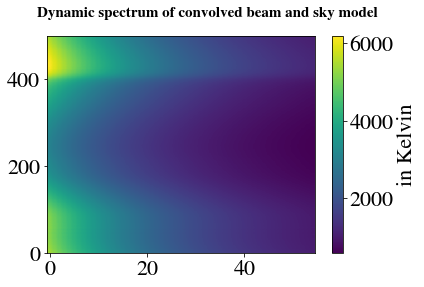

In [57]:
plt.figure()
plt.imshow(T_SKY , aspect='auto', origin='lower') 
plt.suptitle('Dynamic spectrum of convolved beam and sky model ',fontsize=15, fontweight="bold")
cbar=plt.colorbar()
cbar.set_label('in Kelvin')
plt.show()

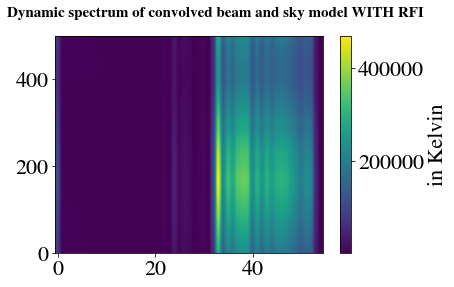

In [58]:
plt.figure()
plt.imshow(T_RFI , aspect='auto', origin='lower') 
plt.suptitle('Dynamic spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")
cbar=plt.colorbar()
cbar.set_label('in Kelvin')
plt.show()

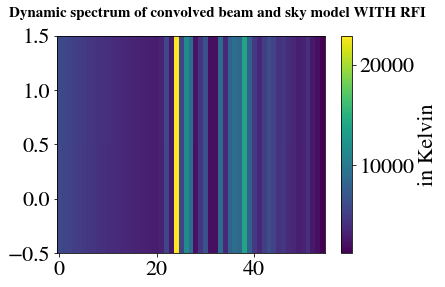

In [41]:
plt.figure()
plt.imshow(T_RFI , aspect='auto', origin='lower') 
plt.suptitle('Dynamic spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")
cbar=plt.colorbar()
cbar.set_label('in Kelvin')
plt.show()

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

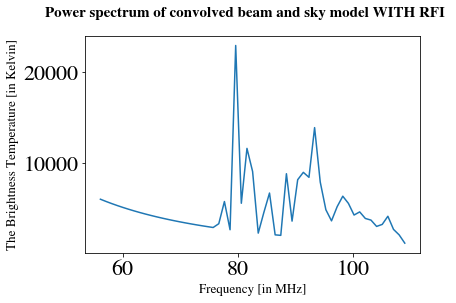

In [42]:
plt.plot(freq,T_RFI[0])
#plt.yscale("log")
#plt.ylim(0,25000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

In [148]:
T_RFI[0]-T_SKY[0]

array([-9.75218804e+00, -9.35166053e+00, -8.97368353e+00, -8.61665565e+00,
       -8.27911129e+00, -7.95970822e+00, -7.65721455e+00, -7.37049978e+00,
       -7.09852393e+00, -6.84032868e+00, -6.59503208e+00, -6.36181847e+00,
       -6.13993539e+00, -5.92868637e+00, -5.72742620e+00, -5.53555692e+00,
       -5.35252403e+00, -5.17781197e+00, -5.01094180e+00, -4.85146751e+00,
       -4.69897373e+00,  3.76978285e+02,  2.27692660e+03,  4.49724164e+00,
        1.53150537e+04,  2.31253559e+03,  6.90955793e+03,  5.05000593e+03,
       -4.49057299e-02,  1.76287575e+03,  3.41297413e+03, -3.38771243e+00,
       -1.95806902e+00,  1.21986563e+03,  3.33604673e+03,  7.74604535e+03,
        1.33357016e+04,  8.83274402e+03,  1.28731146e+04,  8.76088727e+03,
        7.44454189e+03,  4.08550702e+03,  7.40604026e+03,  7.06093901e+03,
        6.80674492e+03,  5.42711638e+03,  9.18233035e+03,  9.65143226e+03,
        6.43304729e+03,  7.21331641e+03,  6.83005847e+03,  1.01685344e+04,
        6.05815624e+03,  

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

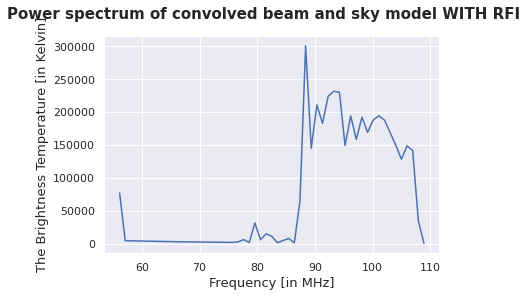

In [70]:
plt.plot(freq,T_RFI[0])
#plt.yscale("log")
#plt.ylim(0,25000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model')

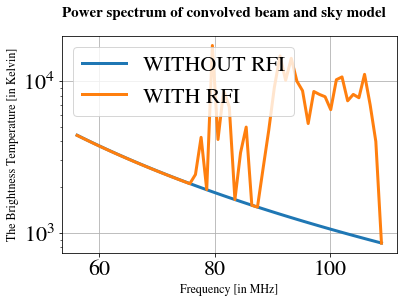

In [149]:
plt.plot(freq,T_SKY[400],lw=3.0,label='WITHOUT RFI')
plt.plot(freq,T_RFI[400],lw=3.0,label='WITH RFI')
plt.yscale("log")
plt.xlabel('Frequency [in MHz]',fontsize=12)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=12)
plt.grid()
plt.legend()
plt.suptitle('Power spectrum of convolved beam and sky model',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model')

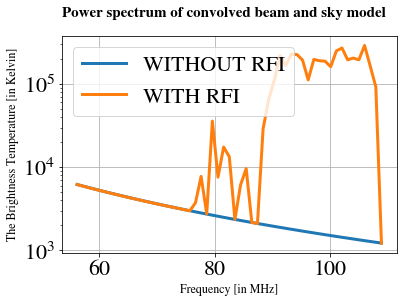

In [104]:
plt.plot(freq,T_SKY[50],lw=3.0,label='WITHOUT RFI')
plt.plot(freq,T_RFI[50],lw=3.0,label='WITH RFI')
plt.yscale("log")
plt.xlabel('Frequency [in MHz]',fontsize=12)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=12)
plt.grid()
plt.legend()
plt.suptitle('Power spectrum of convolved beam and sky model',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model')

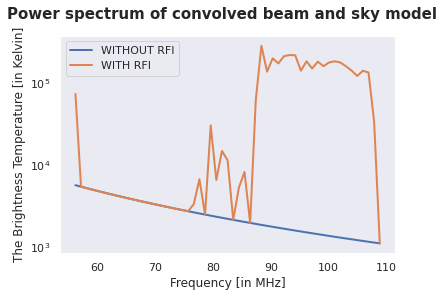

In [76]:
plt.plot(freq,T_SKY[480],lw=2.0,label='WITHOUT RFI')
plt.plot(freq,T_RFI[480],lw=2.0,label='WITH RFI')
plt.yscale("log")
plt.xlabel('Frequency [in MHz]',fontsize=12)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=12)
plt.grid()
plt.legend()
plt.suptitle('Power spectrum of convolved beam and sky model',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

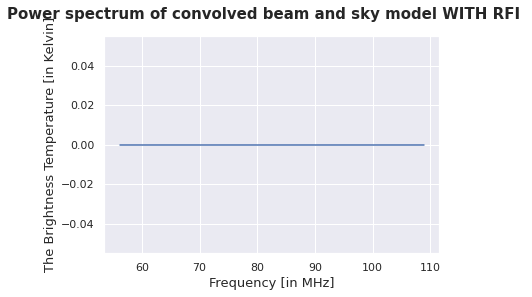

In [63]:
plt.plot(freq,T_monopole_RFI[0])
#plt.yscale("log")
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

In [129]:
T_monopole_RFI[0]-T_RFI[0]

array([-4.06345185e+00, -4.07642571e+00, -4.09553455e+00, -4.11610123e+00,
       -4.12969502e+00, -4.10545110e+00, -4.07998104e+00, -4.06747919e+00,
       -4.06655652e+00, -4.06292212e+00, -3.97146332e+00, -3.87859070e+00,
       -3.85734484e+00, -3.94163473e+00, -4.01772464e+00, -4.00960405e+00,
       -3.98346602e+00, -3.93578760e+00, -3.83123079e+00, -3.73143859e+00,
       -3.71058774e+00,  2.71713560e+01,  1.69438435e+02, -3.04231868e+00,
        9.60990344e+02,  1.25219545e+02,  3.25310891e+02,  1.96317056e+02,
       -3.37531910e+00,  3.37838987e+01,  3.55129160e+01, -3.41609185e+00,
       -3.45734376e+00, -3.33549957e+02, -8.91397972e+02, -2.07753556e+03,
       -5.19332350e+03, -4.75980403e+03, -7.63201783e+03, -8.68955391e+03,
       -8.35350027e+03, -5.31452912e+03, -1.03387064e+04, -1.08106615e+04,
       -1.14787154e+04, -1.05340856e+04, -1.73769187e+04, -1.99410948e+04,
       -1.51296996e+04, -1.66657290e+04, -1.66186766e+04, -2.58624959e+04,
       -1.52738044e+04, -

In [125]:
  T_monopole_sky[1]- T_monopole_sky[0]

array([25.22936333, 24.14723173, 23.13260771, 22.17802374, 21.27660968,
       20.4434632 , 19.65374688, 18.88922676, 18.14893446, 17.44629382,
       16.78551743, 16.15784654, 15.56073593, 14.99228065, 14.45094219,
       13.93006124, 13.43244167, 12.95932189, 12.51198542, 12.08482971,
       11.66903192, 11.26851171, 10.8836125 , 10.50342875, 10.1398996 ,
        9.78858502,  9.44994554,  9.12587014,  8.81754407,  8.5221569 ,
        8.23278481,  7.94832716,  7.67573279,  7.40246367,  7.13931599,
        6.8888453 ,  6.65199391,  6.42474899,  6.19874953,  5.97973085,
        5.77049559,  5.57289499,  5.38303671,  5.19364541,  5.00823294,
        4.83063946,  4.66460164,  4.50493021,  4.34659629,  4.19035988,
        4.04008555,  3.89651809,  3.75837093,  3.62487703,  3.49566351])

In [126]:
T_SKY[1]-T_SKY[0]

array([26.95705469, 25.88932756, 24.87926287, 23.92295735, 23.01681912,
       22.15754767, 21.34209272, 20.56764844, 19.83162136, 19.13161077,
       18.46540127, 17.83093396, 17.22630504, 16.64974546, 16.09961176,
       15.57437488, 15.07261292, 14.59300155, 14.13430629, 13.69537464,
       13.27512984, 12.87256686, 12.48674548, 12.11678336, 11.76185842,
       11.42119592, 11.09406997, 10.7798003 , 10.47774746, 10.18730937,
        9.90792083,  9.63905016,  9.3801936 ,  9.1308794 ,  8.89066333,
        8.65912186,  8.43586018,  8.22050093,  8.01269058,  7.81209368,
        7.61839105,  7.43128425,  7.2504873 ,  7.07572979,  6.90675698,
        6.74332446,  6.58520224,  6.43217077,  6.28402384,  6.14056149,
        6.00159635,  5.86694911,  5.73645053,  5.60993763,  5.48725506])

In [127]:
T_monopole_RFI[1]-T_monopole_RFI[0]

array([  25.21760417,   24.13603129,   23.12193888,   22.16785929,
         21.26691844,   20.43417057,   19.64483259,   18.88069823,
         18.14079746,   17.43852804,   16.77807729,   16.15071426,
         15.55390318,   14.98574337,   14.44468577,   13.92409327,
         13.42675223,   12.95389211,   12.50678879,   12.0798549 ,
         11.66428423,    8.80356008,   -3.80616647,   10.44296113,
        -88.10840758,   -5.02666073,  -34.58660156,  -22.94207481,
          8.79144084,   -2.59993472,  -13.19778122,    7.9457916 ,
          7.66504299,  -96.90005773, -173.5006435 , -303.56263998,
       -606.66984558, -457.79480236, -626.84634642, -620.19814433,
       -526.44903723, -298.61364435, -531.7765915 , -511.21363921,
       -503.57153493, -430.42770093, -669.23601335, -723.94630104,
       -518.54284116, -542.8233962 , -515.25342852, -766.67305367,
       -430.94872837, -236.94590358,    3.49579423])

In [128]:
T_RFI[1]-T_RFI[0]

array([  26.94469011,   25.87741709,   24.86778433,   23.91188987,
         23.00614306,   22.14724452,   21.33214504,   20.5580398 ,
         19.82233625,   19.12263455,   18.45672011,   17.82253481,
         17.21817555,   16.64187396,   16.09198719,   15.56698677,
         15.06545137,   14.58605716,   14.12757015,   13.68883828,
         13.26878525,   10.39087558,   -2.32150103,   12.05402188,
        -87.64103279,   -3.6151083 ,  -33.76867095,  -22.01653022,
         10.44904846,   -1.27912451,  -12.26424227,    9.63438514,
          9.36697539,  -99.97653582, -180.98480497, -319.05485169,
       -641.02419912, -484.90599073, -668.02037875, -664.84304066,
       -567.37545533, -322.85352907, -578.92527016, -558.26059286,
       -551.12906868, -471.98377746, -737.06046265, -800.0634673 ,
       -574.56446336, -603.56410814, -574.76941811, -859.66577904,
       -484.67023758, -266.69045967,    5.4845571 ])

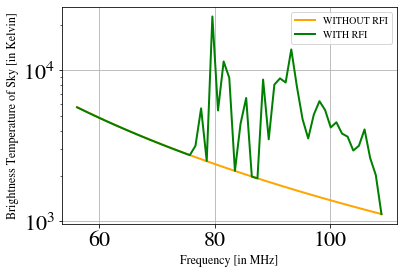

In [223]:
plt.plot(freq,T_SKY[480],lw=2.0,label='WITHOUT RFI', color='orange')
plt.plot(freq,T_RFI[480],lw=2.0,label='WITH RFI', color='green')
plt.yscale("log")
plt.xlabel('Frequency [in MHz]',fontsize=12)
plt.ylabel('Brightness Temperature of Sky [in Kelvin]',fontsize=12)
plt.grid()
plt.legend(fontsize=10)
#plt.suptitle('Power spectrum of convolved beam and sky model',fontsize=15, fontweight="bold")

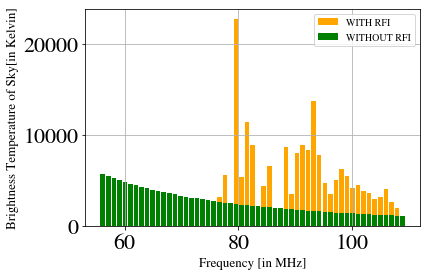

In [220]:
#plt.bar(freq,T_SKY[480],lw=2.0,label='WITH RFI', color='green')
plt.bar(freq,T_RFI[480],label='WITH RFI', color='orange')
plt.bar(freq,T_SKY[480],label='WITHOUT RFI', color='green')
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 20000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('Brightness Temperature of Sky[in Kelvin]',fontsize=13)
plt.grid()
plt.legend(fontsize=10)
#plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

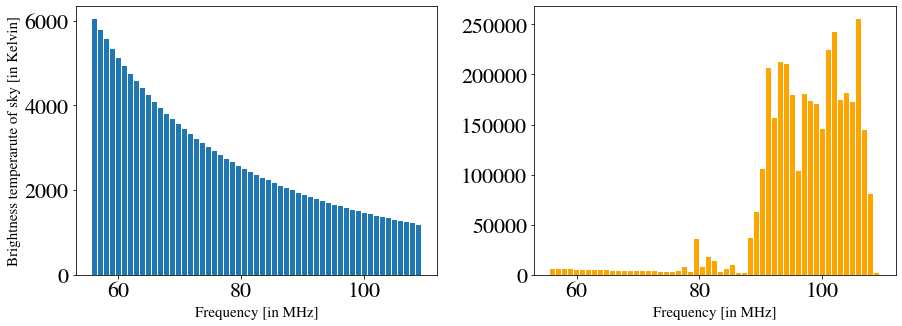

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2,  figsize=(13, 5),sharex=True)
ax = axs[0]
ax.bar(freq,T_monopole_sky[4])
ax.set_ylabel('Brightness temperarute of sky [in Kelvin]', fontsize=15)
ax.set_xlabel('Frequency [in MHz]', fontsize=15)
##ax.legend(fontsize=12)

ax = axs[1]
ax.bar(freq,T_monopole_RFI[4], color='orange')
ax.set_xlabel('Frequency [in MHz]', fontsize=15)
plt.tight_layout()

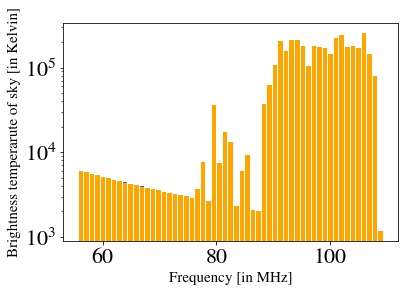

In [137]:
#Plots for brightness temperature of the sky with RFI for PRATUSH beam
plt.bar(freq,T_monopole_sky[1])
plt.ylabel('Brightness temperarute of sky [in Kelvin]', fontsize=15)
plt.xlabel('Frequency [in MHz]', fontsize=15)

plt.bar(freq,T_monopole_RFI[1], color='orange')
plt.xlabel('Frequency [in MHz]', fontsize=15)
plt.ylabel('Brightness temperarute of sky [in Kelvin]', fontsize=15)
plt.yscale("log")

Text(0.5, 0, 'Frequency [in MHz]')

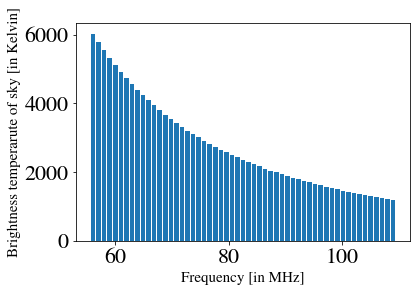

In [132]:
#fPlots for brightness temperature of the sky without RFI for PRATUSH beam
plt.bar(freq,T_monopole_sky[1])
plt.ylabel('Brightness temperarute of sky [in Kelvin]', fontsize=15)
plt.xlabel('Frequency [in MHz]', fontsize=15)

Text(0.5, 0, 'Frequency [in MHz]')

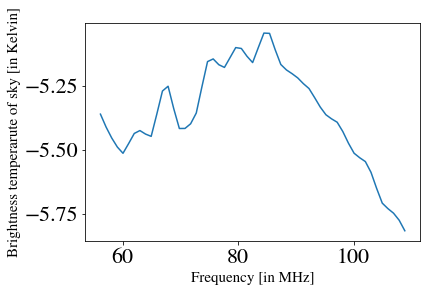

In [138]:
#Difference between PRATUSH beam and cos2 beam without log scale
plt.plot(freq,T_monopole_sky[1]-T_SKY[1])
plt.ylabel('Brightness temperarute of sky [in Kelvin]', fontsize=15)
plt.xlabel('Frequency [in MHz]', fontsize=15)

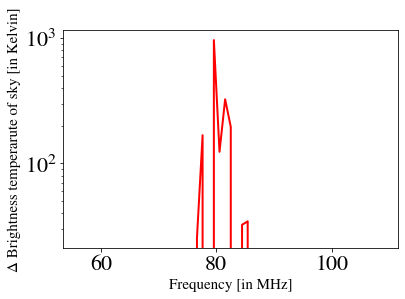

In [143]:
#Difference between PRATUSH beam and cos2 beam with log scale
plt.plot(freq,T_monopole_RFI[1]-T_RFI[1], linewidth=2, color='r')
plt.ylabel('\u0394 Brightness temperarute of sky [in Kelvin]', fontsize=15)
plt.xlabel('Frequency [in MHz]', fontsize=15)
plt.yscale("log")

Text(0.5, 0, 'Frequency [in MHz]')

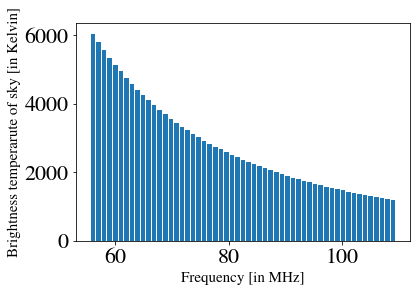

In [136]:
#fPlots for brightness temperature of the sky without RFI for cos2 beam
plt.bar(freq,T_SKY[1])
plt.ylabel('Brightness temperarute of sky [in Kelvin]', fontsize=15)
plt.xlabel('Frequency [in MHz]', fontsize=15)
#plt.yscale("log")

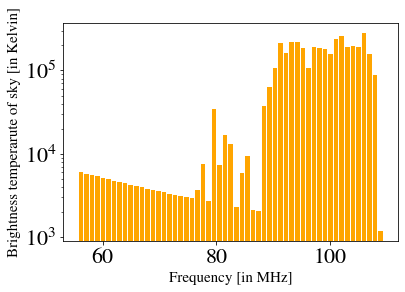

In [134]:
#fPlots for brightness temperature of the sky with RFI for cos2 beam
plt.bar(freq,T_RFI[1],color='orange')
plt.ylabel('Brightness temperarute of sky [in Kelvin]', fontsize=15)
plt.xlabel('Frequency [in MHz]', fontsize=15)
plt.yscale("log")

In [145]:
#PLEASE IGNORE THE FOLLOWING PLOTS

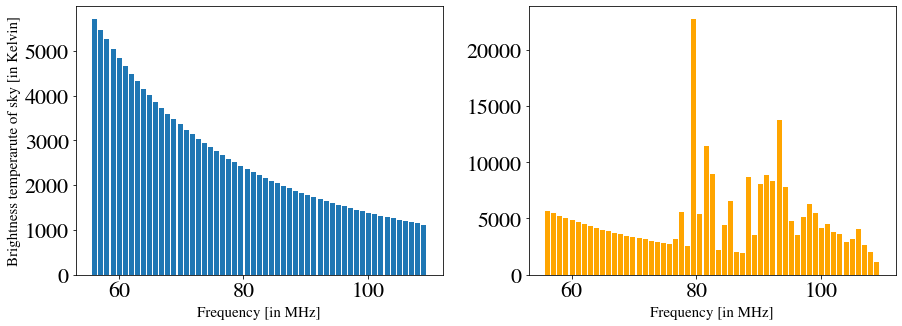

In [70]:
fig, axs = plt.subplots(nrows=1, ncols=2,  figsize=(13, 5),sharex=True)
ax = axs[0]
ax.bar(freq,T_SKY[480])
ax.set_ylabel('Brightness temperarute of sky [in Kelvin]', fontsize=15)
ax.set_xlabel('Frequency [in MHz]', fontsize=15)
##ax.legend(fontsize=12)

ax = axs[1]
ax.bar(freq,T_RFI[480], color='orange')
ax.set_xlabel('Frequency [in MHz]', fontsize=15)
plt.tight_layout()
#ax.legend(fontsize=12)

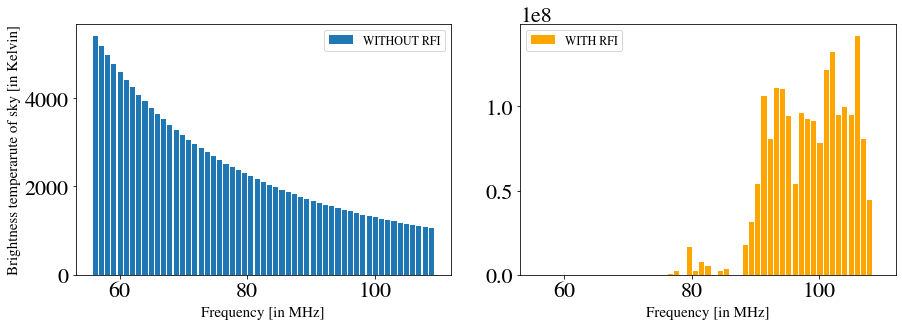

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=2,  figsize=(13, 5),sharex=True)
ax = axs[0]
ax.bar(freq,T_SKY[480],label='WITHOUT RFI')
ax.set_ylabel('Brightness temperarute of sky [in Kelvin]', fontsize=15)
ax.set_xlabel('Frequency [in MHz]', fontsize=15)
ax.legend(fontsize=12)

ax = axs[1]
ax.bar(freq,T_RFI[480],label='WITH RFI', color='orange')
ax.set_xlabel('Frequency [in MHz]', fontsize=15)
plt.tight_layout()
ax.legend(fontsize=12)